In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.impute import SimpleImputer

In [13]:
try:
    # Use the uploaded file name
    df = pd.read_csv("data/train.csv")
    print("Successfully loaded train.csv")
except FileNotFoundError:
    print("Error: train.csv not found. Make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

Successfully loaded train.csv


In [14]:
print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- DataFrame Info ---")
df.info()

print(f"\n--- DataFrame Shape ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")


--- First 5 Rows ---
            Hospital_Id       Supplier_Name  Supplier_Reliability  \
0  fffe3200360030003700         Jo Valencia                  0.44   
1  fffe3400380037003400        Wanda Warren                  0.58   
2  fffe3200350036003700       Robert Ackies                  0.97   
3  fffe3800320034003400  Charlotte Membreno                  0.70   
4  fffe3600340033003000          Nena Silva                  0.66   

   Equipment_Height  Equipment_Width  Equipment_Weight Equipment_Type  \
0              21.0              6.0               NaN            NaN   
1              29.0             20.0         1210684.0         Marble   
2              39.0             15.0            3305.0      Aluminium   
3               8.0              5.0             606.0          Brass   
4              27.0             13.0               NaN         Marble   

   Equipment_Value  Base_Transport_Fee CrossBorder_Shipping Urgent_Shipping  \
0             3.62               17.13       


--- Missing Values Per Column ---
Hospital_Id                0
Supplier_Name              0
Supplier_Reliability     587
Equipment_Height         283
Equipment_Width          443
Equipment_Weight         460
Equipment_Type           599
Equipment_Value            0
Base_Transport_Fee         0
CrossBorder_Shipping       0
Urgent_Shipping            0
Installation_Service       0
Transport_Method        1071
Fragile_Equipment          0
Hospital_Info              0
Rural_Hospital           586
Order_Placed_Date          0
Delivery_Date              0
Hospital_Location          0
Transport_Cost             0
dtype: int64
Total missing values: 4029

--- Missing Values Visualization ---


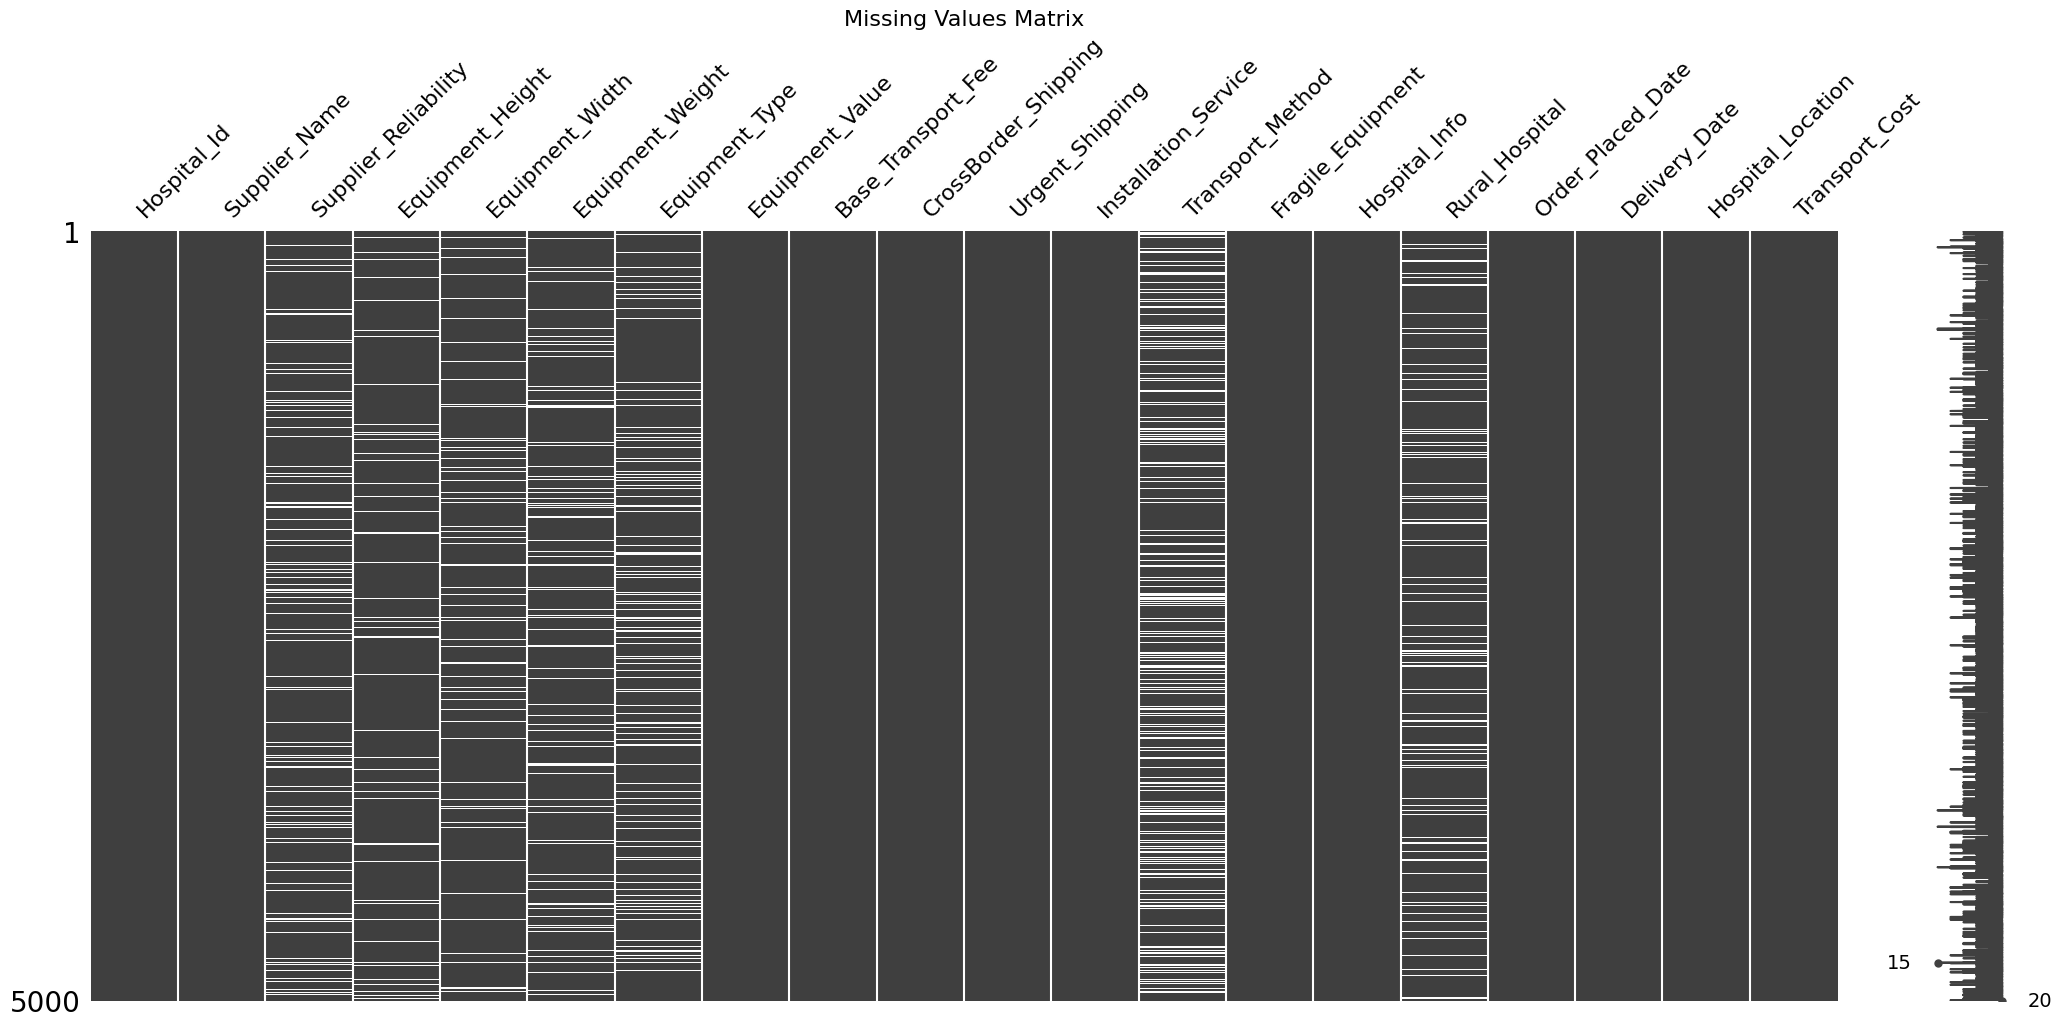


--- Imputing missing values in numerical columns (['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight']) using mean ---
Imputation complete.

--- Imputing missing values in categorical columns (['Equipment_Type', 'Transport_Method', 'Rural_Hospital']) using most frequent ---
Imputation complete.

--- Missing Values After Initial Imputation ---
Total missing values now: 0


In [15]:
print("\n--- Missing Values Per Column ---")
missing_values = df.isnull().sum()
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

# Visualize missing values pattern
if missing_values.sum() > 0:
    print("\n--- Missing Values Visualization ---")
    msno.matrix(df)
    plt.title("Missing Values Matrix", fontsize=16)
    plt.show()

    # --- Placeholder for Missing Value Imputation ---
    # Identify numerical columns with missing values
    numerical_cols_missing = df.select_dtypes(include=np.number).isnull().sum()
    numerical_cols_to_impute = numerical_cols_missing[numerical_cols_missing > 0].index.tolist()

    if numerical_cols_to_impute:
        print(f"\n--- Imputing missing values in numerical columns ({numerical_cols_to_impute}) using mean ---")
        imputer_mean = SimpleImputer(strategy='mean')
        df[numerical_cols_to_impute] = imputer_mean.fit_transform(df[numerical_cols_to_impute])
        print("Imputation complete.")

    # Identify categorical columns with missing values
    categorical_cols_missing = df.select_dtypes(include='object').isnull().sum()
    categorical_cols_to_impute = categorical_cols_missing[categorical_cols_missing > 0].index.tolist()

    if categorical_cols_to_impute:
        print(f"\n--- Imputing missing values in categorical columns ({categorical_cols_to_impute}) using most frequent ---")
        imputer_mode = SimpleImputer(strategy='most_frequent')
        df[categorical_cols_to_impute] = imputer_mode.fit_transform(df[categorical_cols_to_impute])
        print("Imputation complete.")

    # Verify imputation
    print("\n--- Missing Values After Initial Imputation ---")
    print(f"Total missing values now: {df.isnull().sum().sum()}")
else:
    print("\nNo missing values found initially.")

In [16]:
num_duplicates = df.duplicated().sum()
print(f"\n--- Number of Duplicate Rows ---")
print(num_duplicates)

if num_duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Dropped {num_duplicates} duplicate rows.")
    print(f"New DataFrame Shape: Rows: {df.shape[0]}, Columns: {df.shape[1]}")
else:
    print("No duplicate rows found.")


--- Number of Duplicate Rows ---
0
No duplicate rows found.


In [17]:
transport_col = 'Transport_Cost'

# Check if the column exists and is numerical
if transport_col in df.columns and pd.api.types.is_numeric_dtype(df[transport_col]):
    print(f"\n--- Checking for Negative Values in '{transport_col}' ---")
    negative_values_count = (df[transport_col] < 0).sum()
    print(f"Number of negative values found: {negative_values_count}")

    if negative_values_count > 0:
        print(f"\nStats for negative '{transport_col}' values:")
        print(df[df[transport_col] < 0][[transport_col]].describe())

        # --- Strategy Decision ---
        # Choose ONE strategy and uncomment the corresponding lines:

        # Strategy 1: Replace negatives with 0
        # -------------------------------------
        # df[transport_col] = df[transport_col].apply(lambda x: 0 if x < 0 else x)
        # print(f"\nACTION: Replaced negative values in '{transport_col}' with 0.")

        # Strategy 2: Replace negatives with NaN (treat as missing)
        # --------------------------------------------------------
        df[transport_col] = df[transport_col].apply(lambda x: np.nan if x < 0 else x)
        print(f"\nACTION: Replaced {negative_values_count} negative values in '{transport_col}' with NaN.")

        # Re-check and re-impute NaNs if Strategy 2 was used
        nan_count_after_neg = df[transport_col].isnull().sum()
        print(f"\n--- Missing Values in '{transport_col}' after handling negatives: {nan_count_after_neg} ---")
        if nan_count_after_neg > 0:
            print(f"\n--- Re-imputing NaN values in '{transport_col}' using the mean ---")
            imputer_mean_transport = SimpleImputer(strategy='mean')
            # Reshape is needed when imputing a single column with SimpleImputer
            df[[transport_col]] = imputer_mean_transport.fit_transform(df[[transport_col]])
            print("Re-imputation complete.")
            # Verify imputation again for this column
            print(f"Missing values in '{transport_col}' after re-imputation: {df[transport_col].isnull().sum()}")


        # Strategy 3: Take the absolute value
        # ----------------------------------
        # df[transport_col] = df[transport_col].abs()
        # print(f"\nACTION: Applied absolute value to '{transport_col}'.")

        # Strategy 4: Remove rows with negative values
        # ---------------------------------------------
        # initial_rows = df.shape[0]
        # df = df[df[transport_col] >= 0]
        # rows_removed = initial_rows - df.shape[0]
        # print(f"\nACTION: Removed {rows_removed} rows with negative '{transport_col}'.")
        # print(f"New DataFrame Shape: Rows: {df.shape[0]}, Columns: {df.shape[1]}")

else:
    print(f"\nColumn '{transport_col}' not found or is not numerical. Skipping negative value check.")


--- Checking for Negative Values in 'Transport_Cost' ---
Number of negative values found: 493

Stats for negative 'Transport_Cost' values:
       Transport_Cost
count      493.000000
mean     -6151.206471
std      35227.590453
min    -588183.200000
25%      -1358.730000
50%       -448.220000
75%       -221.410000
max        -96.270000

ACTION: Replaced 493 negative values in 'Transport_Cost' with NaN.

--- Missing Values in 'Transport_Cost' after handling negatives: 493 ---

--- Re-imputing NaN values in 'Transport_Cost' using the mean ---
Re-imputation complete.
Missing values in 'Transport_Cost' after re-imputation: 0


In [18]:
print("\n--- Summary Statistics (Numerical Columns) After Cleaning ---")
# Use describe on potentially cleaned data
print(df.describe(include=np.number).T)

print("\n--- Summary Statistics (Categorical Columns) After Cleaning ---")
# Include object types in describe
if not df.select_dtypes(include='object').empty:
    print(df.describe(include=['object']).T)
else:
    print("No categorical (object type) columns remaining.")


--- Summary Statistics (Numerical Columns) After Cleaning ---
                       count           mean           std    min      25%  \
Supplier_Reliability  5000.0       0.460925  2.498610e-01   0.00    0.270   
Equipment_Height      5000.0      21.759593  1.160141e+01   3.00   13.000   
Equipment_Width       5000.0       9.585034  5.162382e+00   2.00    6.000   
Equipment_Weight      5000.0  409758.435022  2.676299e+06   3.00  609.000   
Equipment_Value       5000.0    1190.293363  8.724804e+03   3.00    5.260   
Base_Transport_Fee    5000.0      37.374362  2.690791e+01  10.00   16.630   
Transport_Cost        5000.0   20528.699030  2.550629e+05  86.07  241.325   

                              50%          75%           max  
Supplier_Reliability     0.460925       0.6400  1.000000e+00  
Equipment_Height        21.759593      29.0000  7.300000e+01  
Equipment_Width          8.000000      11.0000  5.000000e+01  
Equipment_Weight      4554.000000  104261.7500  1.179279e+08  
Equip

In [19]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Define potential target variable - ADJUST IF NEEDED
target_col = 'Transport_Cost' # Set target to Transport_Cost as discussed

if target_col in numerical_cols:
     numerical_cols.remove(target_col) # Separate target from features
elif target_col in df.columns: # If target was non-numeric originally
    print(f"Warning: Target column '{target_col}' is not numerical.")
else:
    print(f"Warning: Target column '{target_col}' not found in DataFrame.")


print("\n--- Final Column Types ---")
print(f"Numerical Features: {numerical_cols}")
print(f"Categorical Features: {categorical_cols}")
if target_col in df.columns:
    print(f"Target Column: {target_col}")


--- Final Column Types ---
Numerical Features: ['Supplier_Reliability', 'Equipment_Height', 'Equipment_Width', 'Equipment_Weight', 'Equipment_Value', 'Base_Transport_Fee']
Categorical Features: ['Hospital_Id', 'Supplier_Name', 'Equipment_Type', 'CrossBorder_Shipping', 'Urgent_Shipping', 'Installation_Service', 'Transport_Method', 'Fragile_Equipment', 'Hospital_Info', 'Rural_Hospital', 'Order_Placed_Date', 'Delivery_Date', 'Hospital_Location']
Target Column: Transport_Cost



--- Distributions of Numerical Features ---


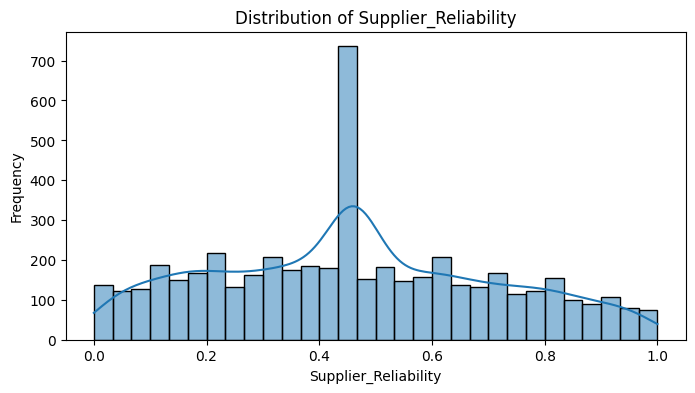

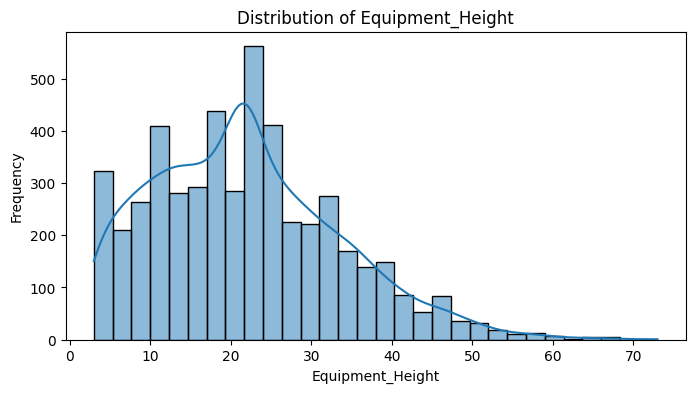

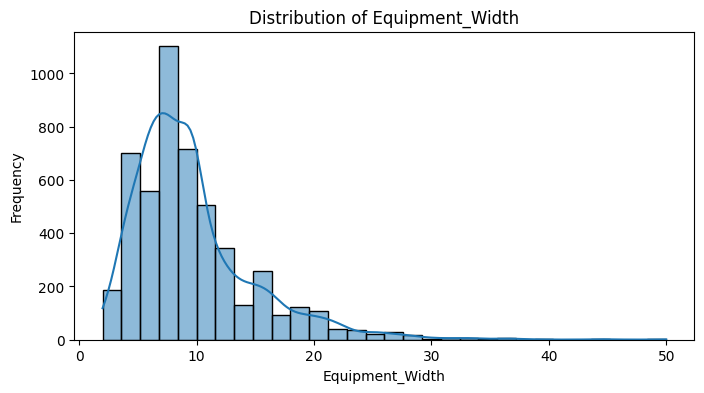

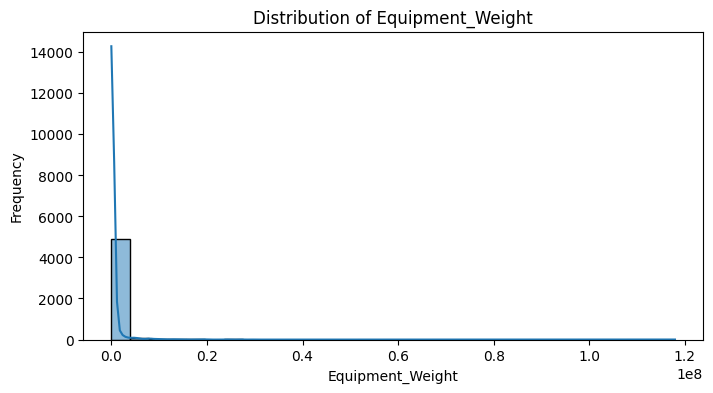

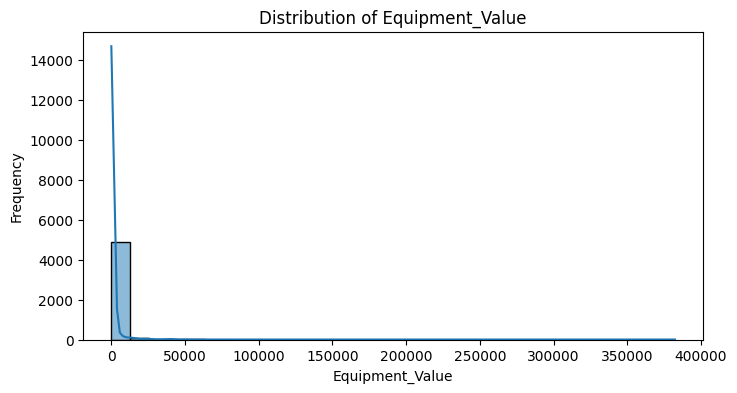

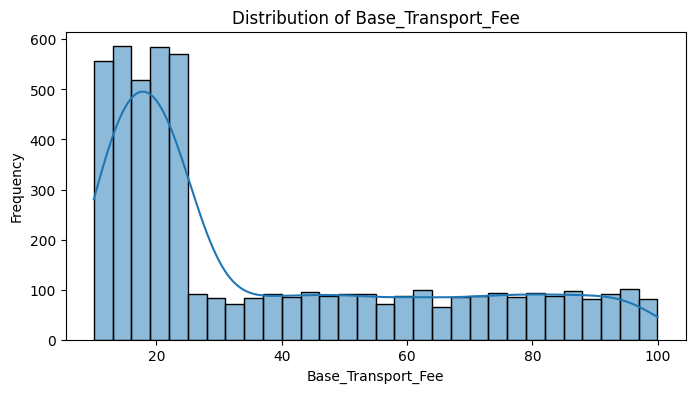


--- Boxplots of Numerical Features ---


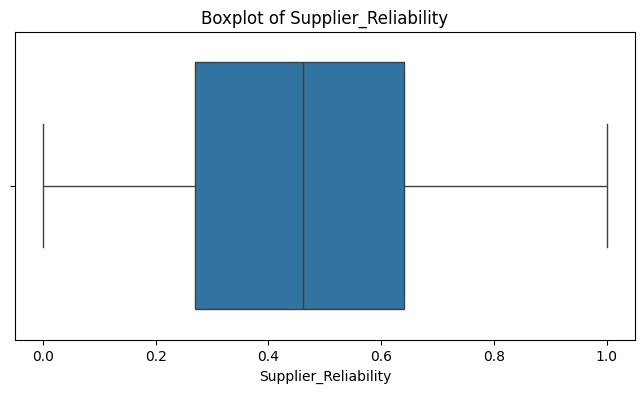

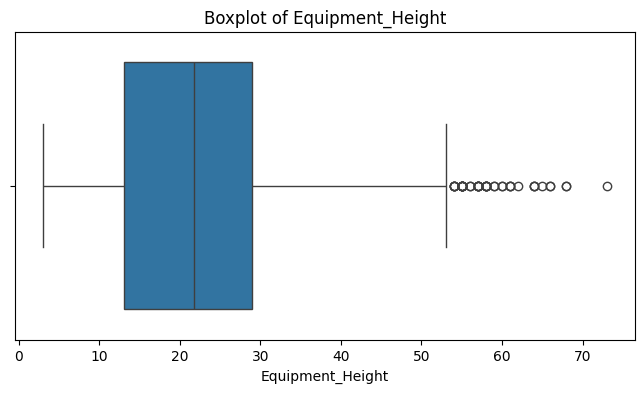

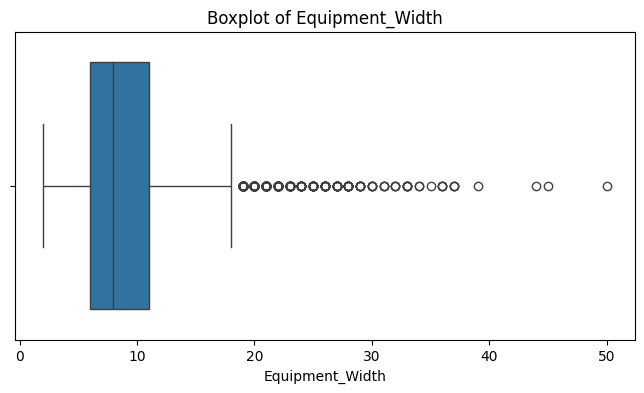

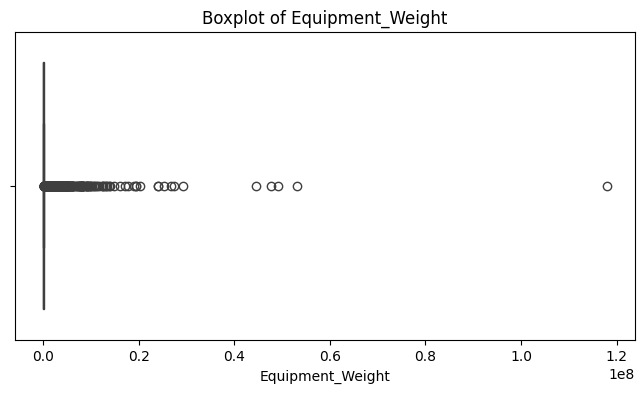

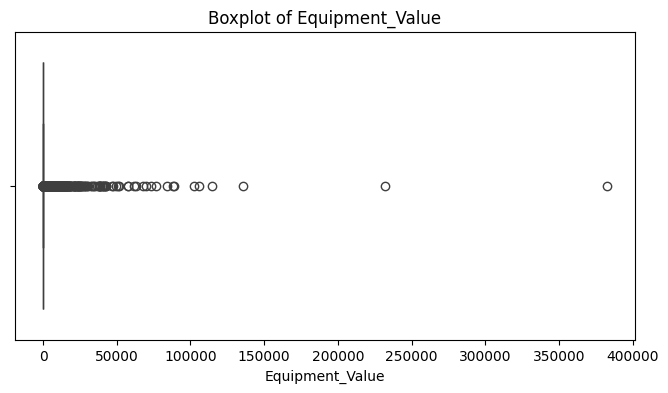

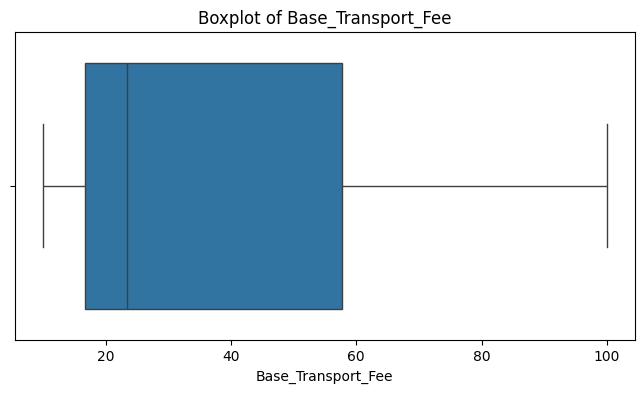


--- Distributions of Categorical Features ---


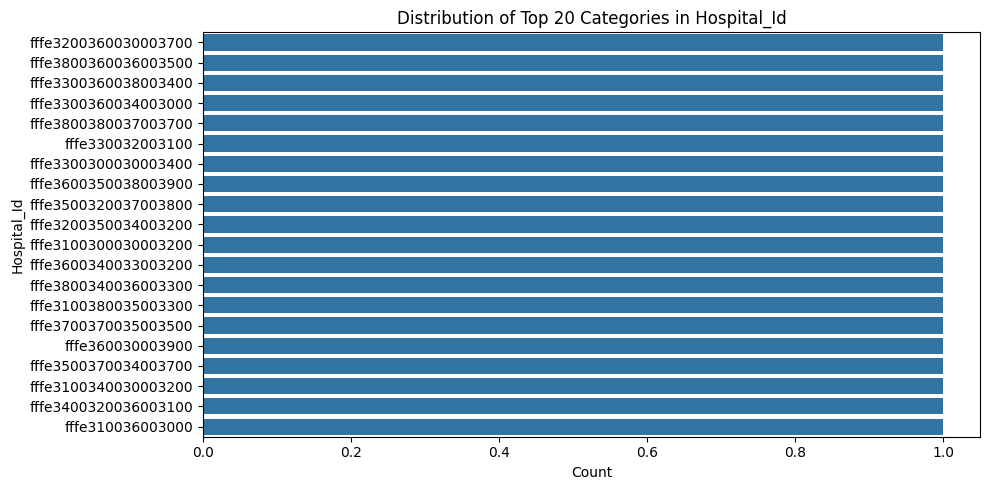

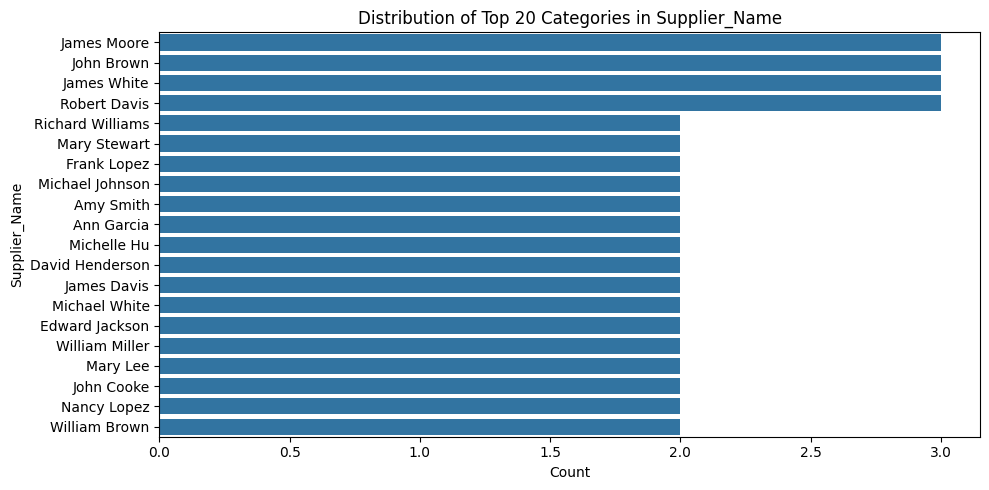

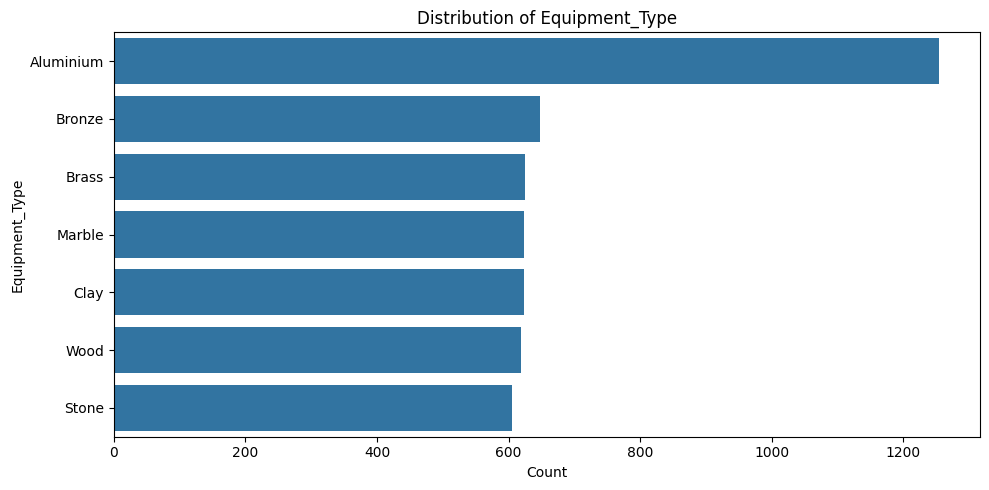

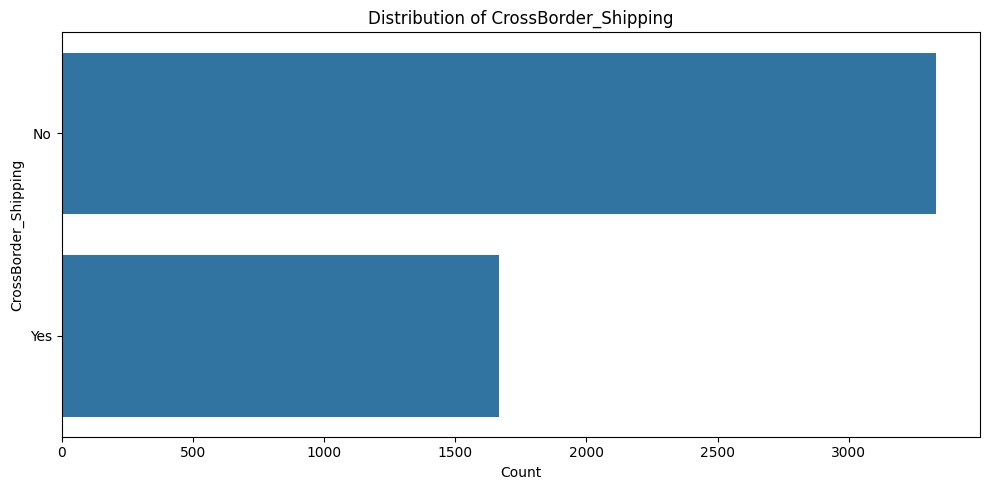

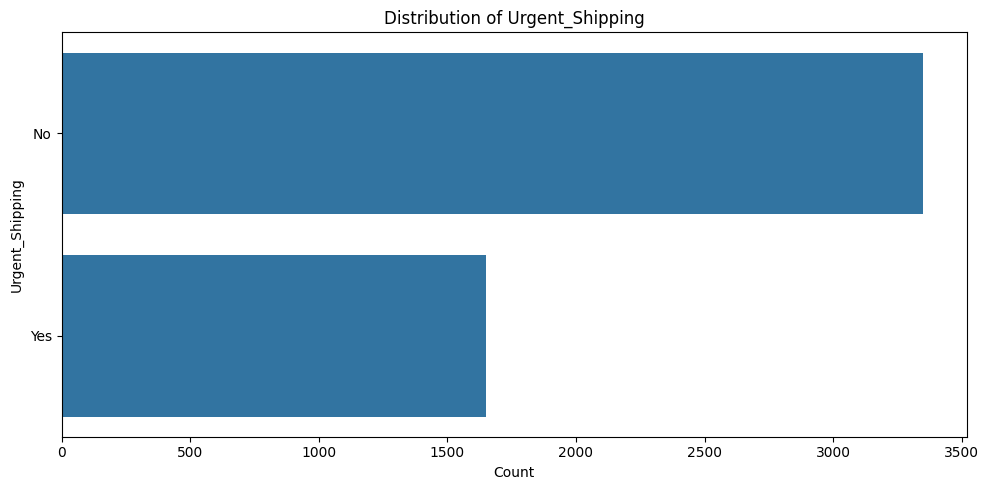

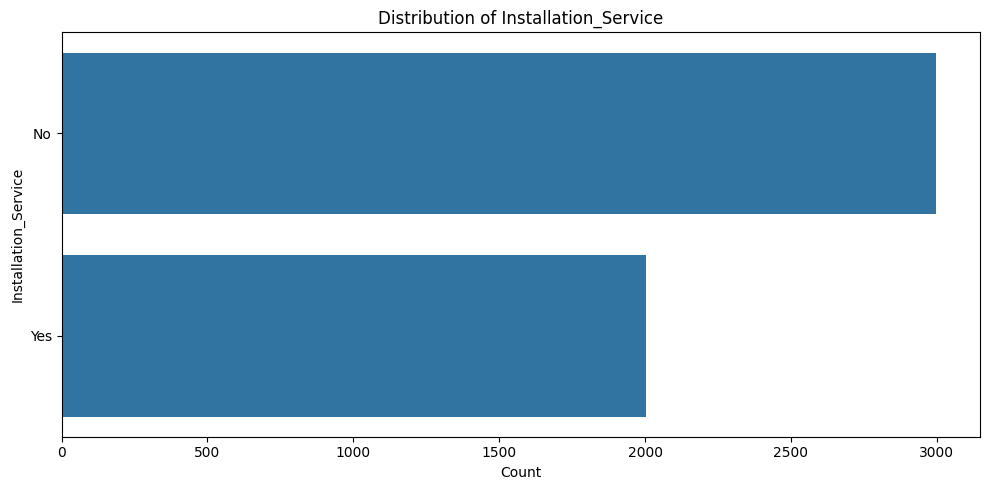

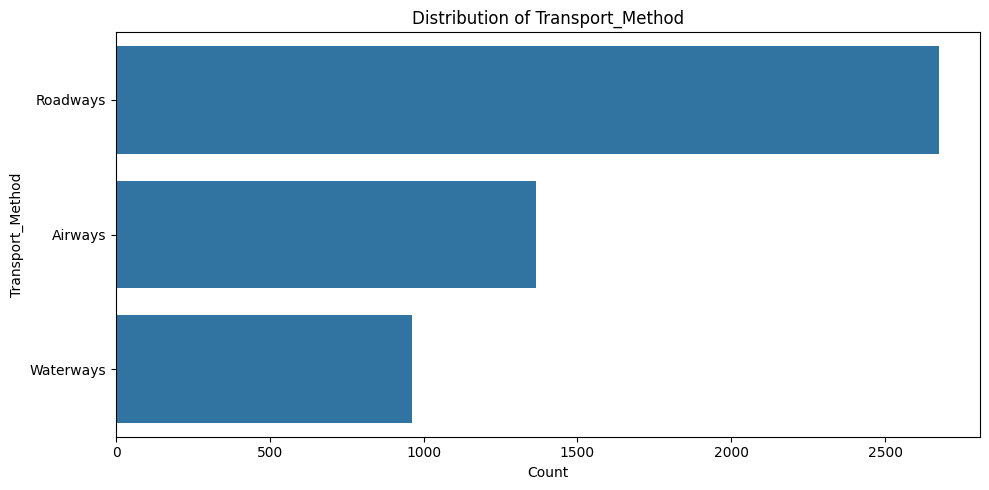

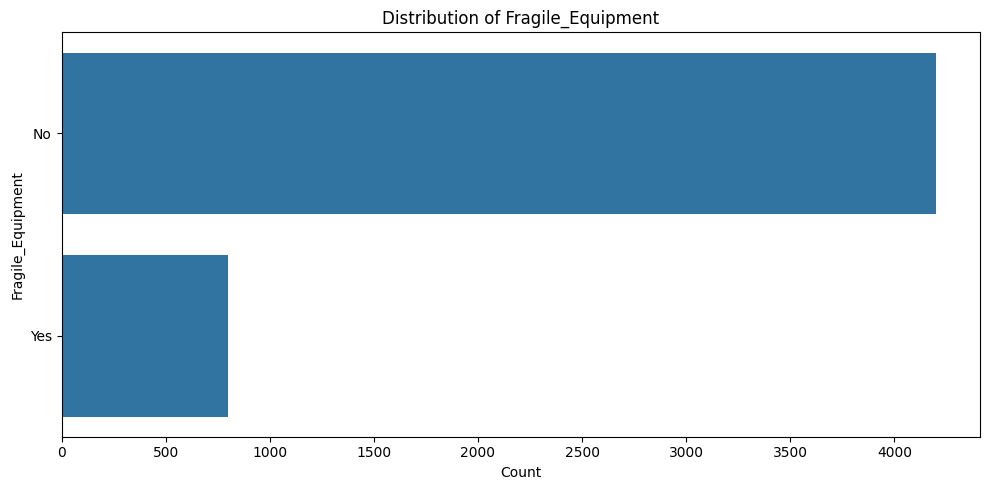

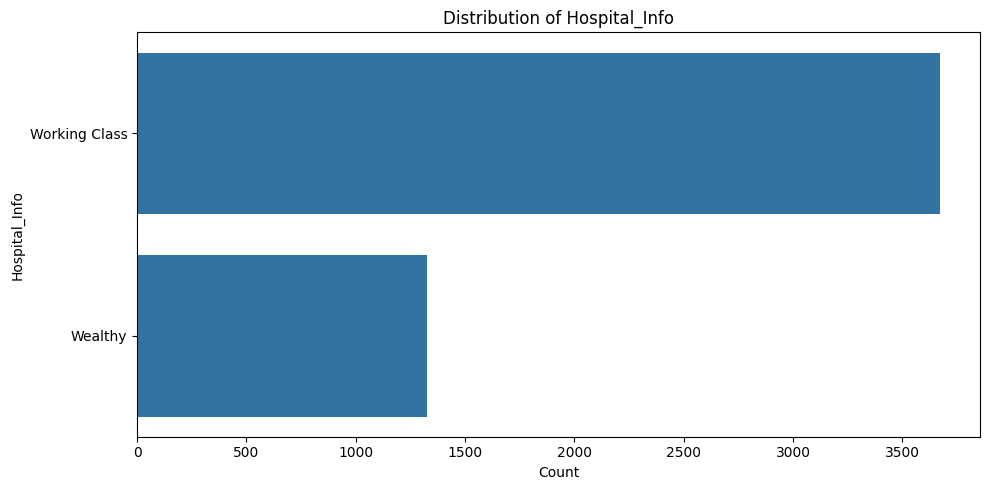

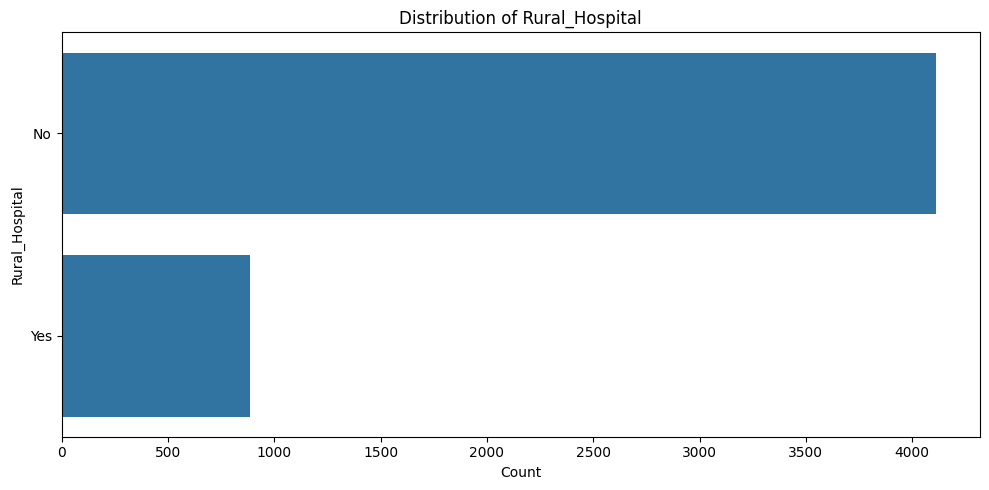

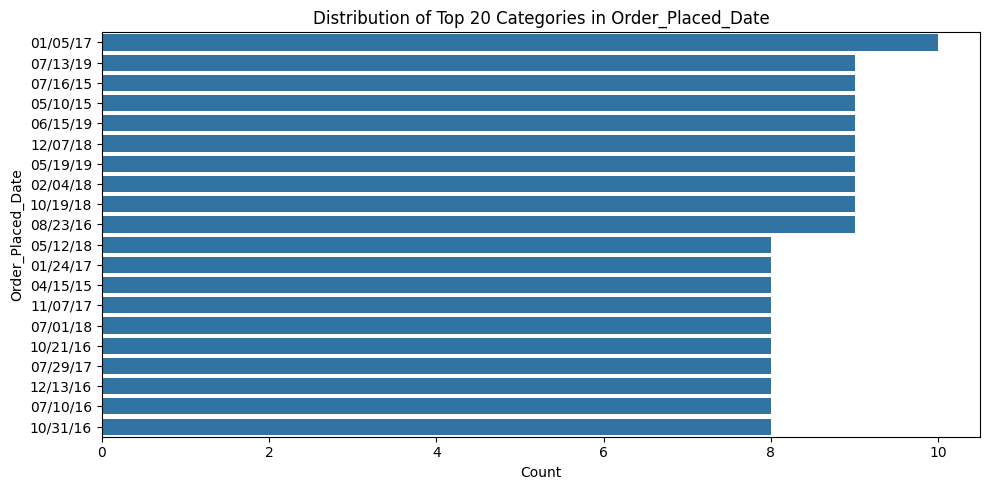

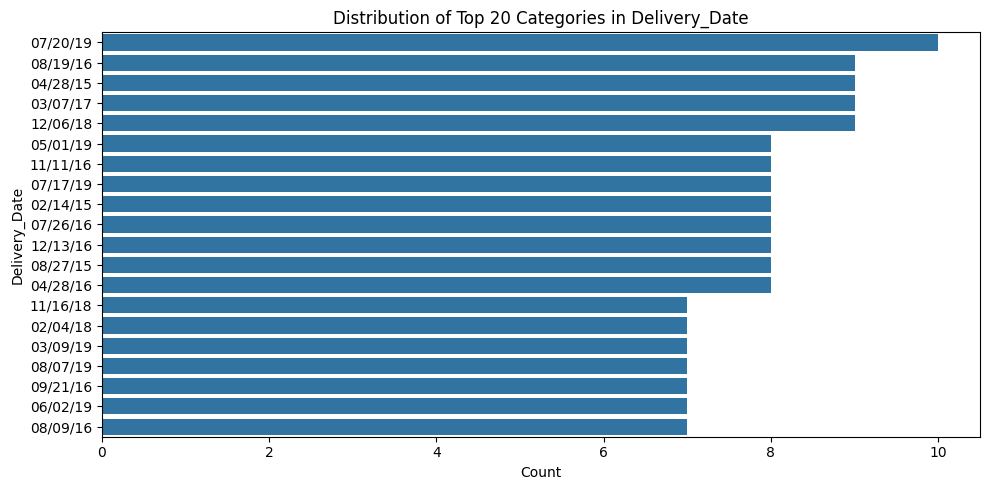

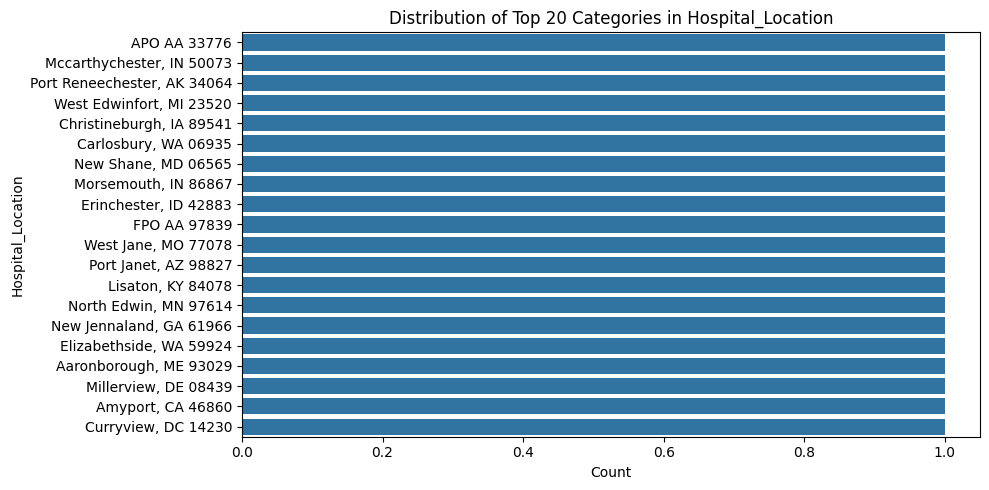

In [20]:
# Numerical Distributions
print("\n--- Distributions of Numerical Features ---")
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True, bins=30) # Use dropna() in case NaNs remain before imputation
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Numerical Boxplots (for outliers)
print("\n--- Boxplots of Numerical Features ---")
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# Categorical Distributions
if categorical_cols: # Only run if categorical columns exist
    print("\n--- Distributions of Categorical Features ---")
    for col in categorical_cols:
        plt.figure(figsize=(10, 5))
        # Handle potential large number of categories
        order = df[col].value_counts().iloc[:20].index # Show top 20
        sns.countplot(y=df[col].dropna(), order=order) # Use y= for horizontal
        if df[col].nunique() > 20:
             plt.title(f'Distribution of Top 20 Categories in {col}')
        else:
             plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
else:
    print("\nNo categorical features to plot.")


--- Correlation Matrix (Numerical Features + Target) ---


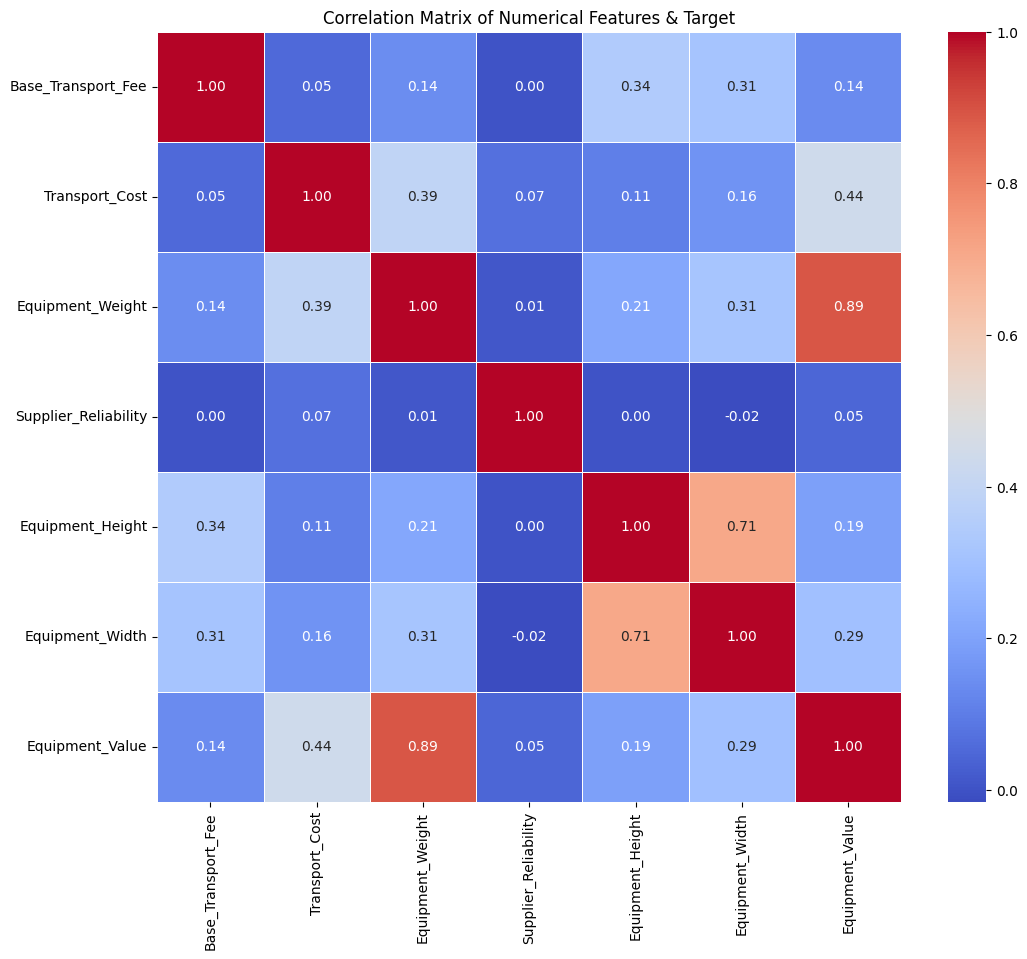

In [21]:
print("\n--- Correlation Matrix (Numerical Features + Target) ---")
# Calculate correlation matrix for numerical columns + target
cols_for_corr = numerical_cols + ([target_col] if target_col in df.columns and target_col not in numerical_cols else [])
# Ensure target_col is included only once if it's numerical
cols_for_corr = list(set(cols_for_corr + ([target_col] if target_col in df.select_dtypes(include=np.number).columns else [])))


if len(cols_for_corr) > 1 and target_col in df.columns : # Need at least 2 columns and target must exist
    plt.figure(figsize=(max(12, len(cols_for_corr)), max(10, len(cols_for_corr)))) # Adjust size
    correlation_matrix = df[cols_for_corr].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Numerical Features & Target')
    plt.show()
elif target_col not in df.columns:
    print(f"Target column '{target_col}' not found, skipping correlation with target.")
    # Optional: Calculate correlation just among features
    if len(numerical_cols) > 1:
        plt.figure(figsize=(max(10, len(numerical_cols)), max(8, len(numerical_cols)))) # Adjust size
        correlation_matrix_features = df[numerical_cols].corr()
        sns.heatmap(correlation_matrix_features, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Numerical Features')
        plt.show()
    else:
        print("Not enough numerical features for feature correlation matrix.")
else:
    print("Not enough numerical columns/target to calculate a correlation matrix.")


--- Numerical Features vs Target (Transport_Cost) ---


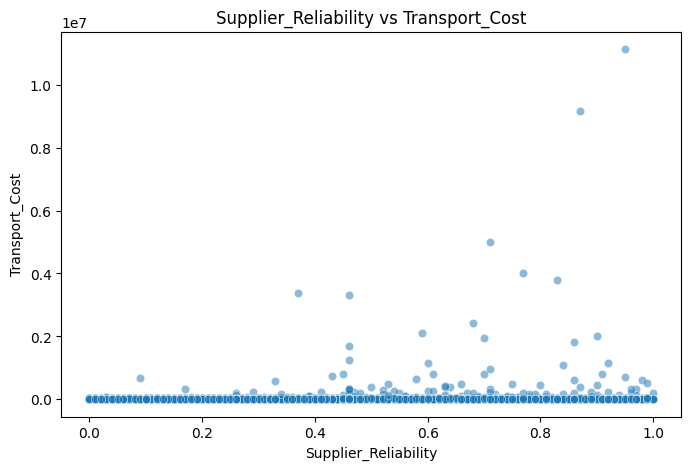

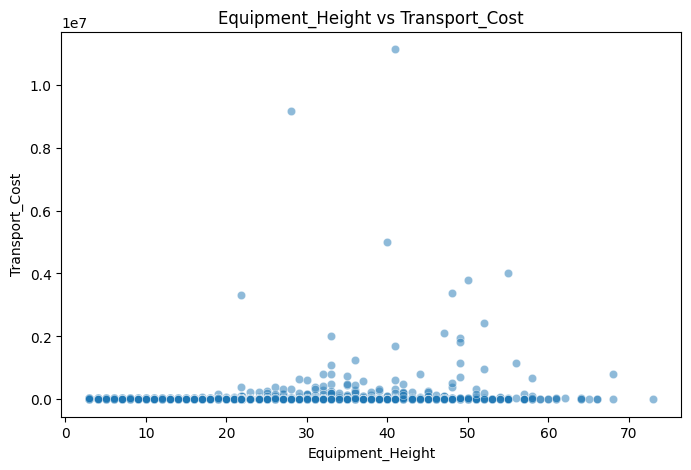

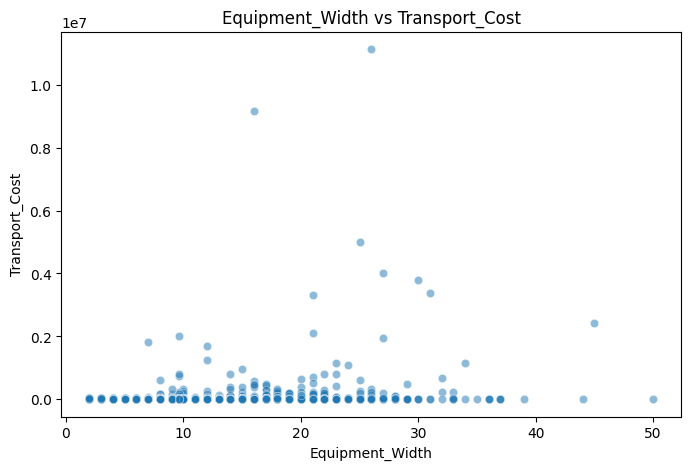

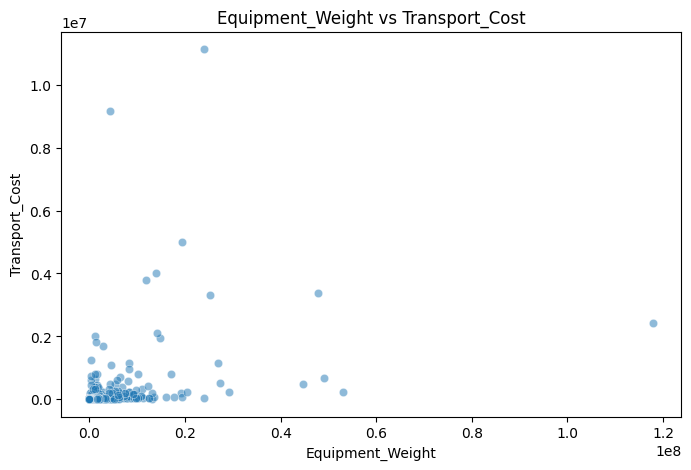

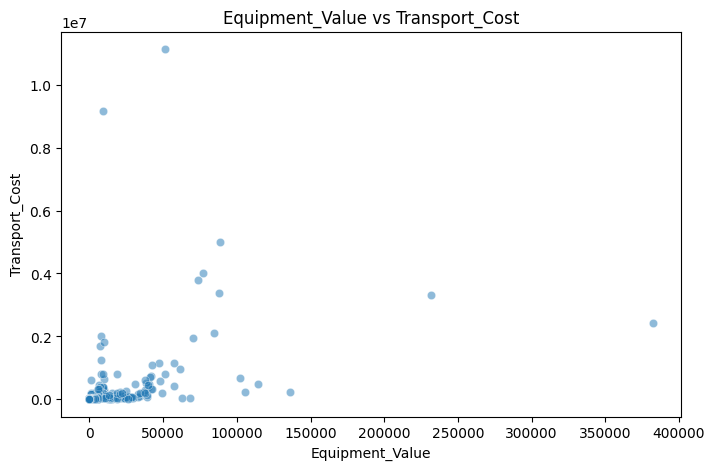

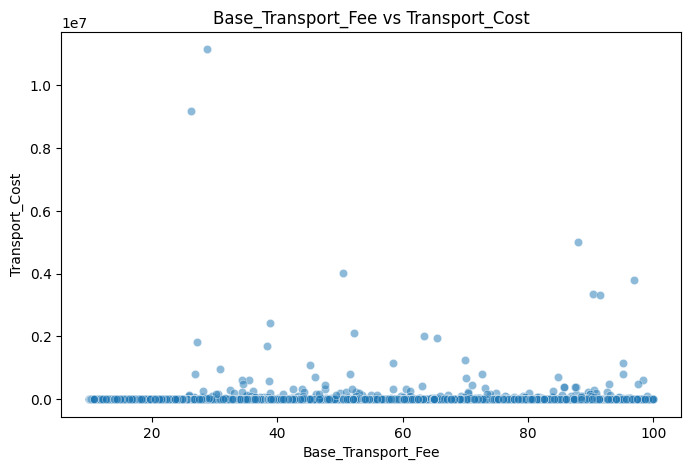

In [22]:
if target_col in df.columns and pd.api.types.is_numeric_dtype(df[target_col]):
    print(f"\n--- Numerical Features vs Target ({target_col}) ---")
    for col in numerical_cols:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=df[col], y=df[target_col], alpha=0.5) # Use scatterplot for continuous target
        plt.title(f'{col} vs {target_col}')
        plt.xlabel(col)
        plt.ylabel(target_col)
        # Optional: Add a regression line
        # sns.regplot(x=df[col], y=df[target_col], scatter_kws={'alpha':0.3})
        plt.show()


--- Categorical Features vs Target (Transport_Cost) ---


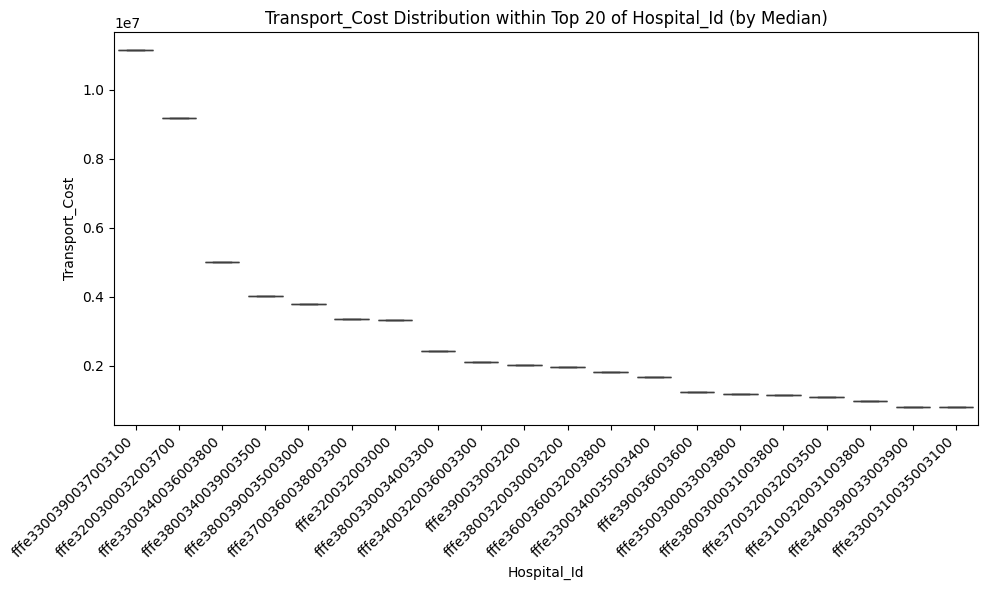

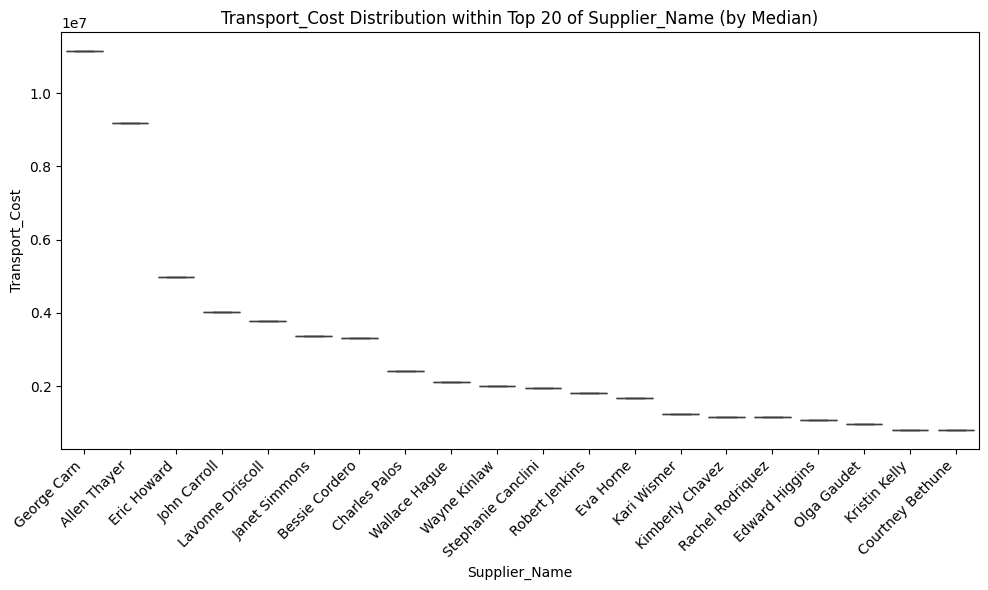

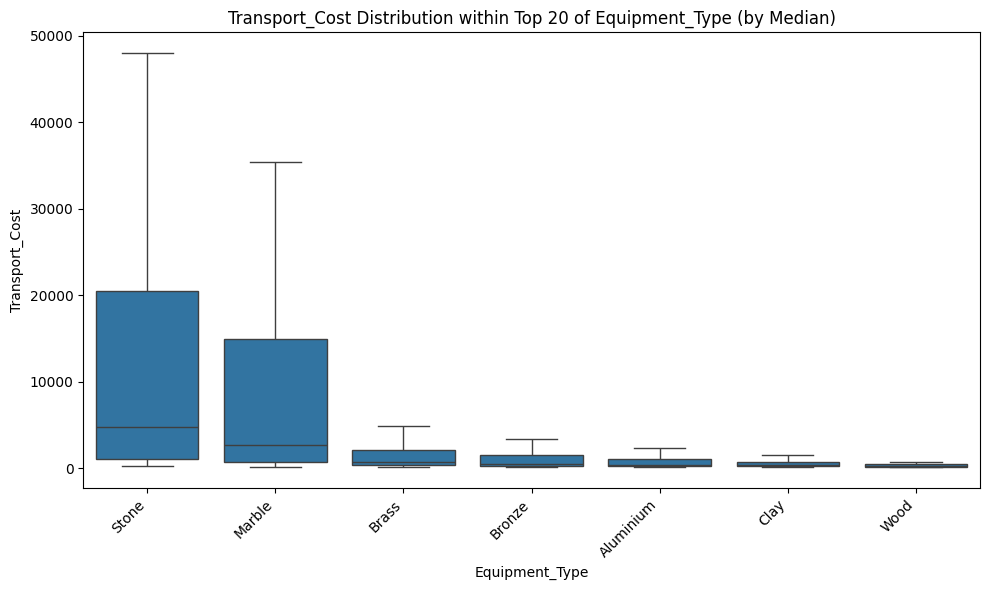

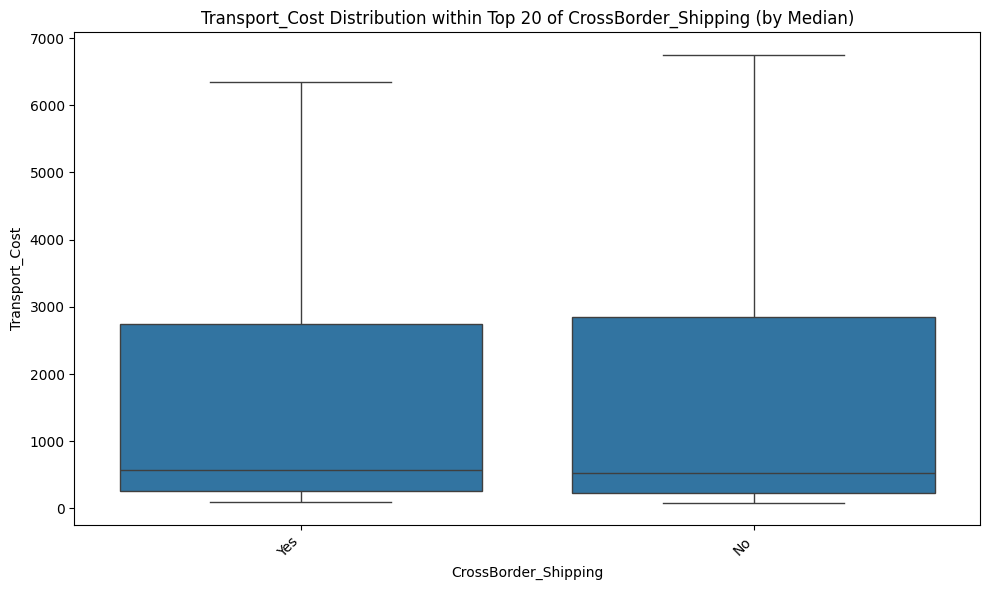

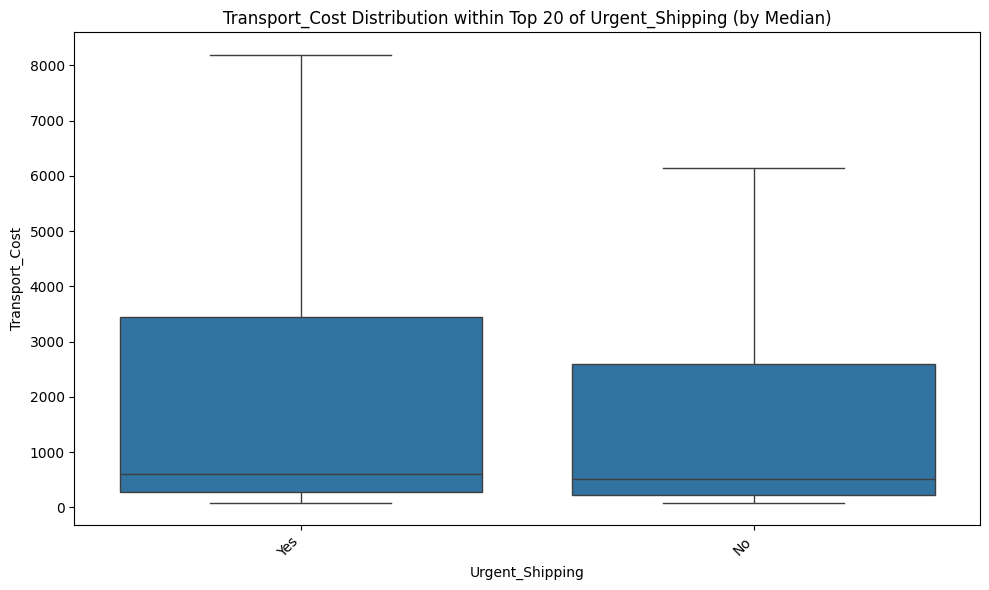

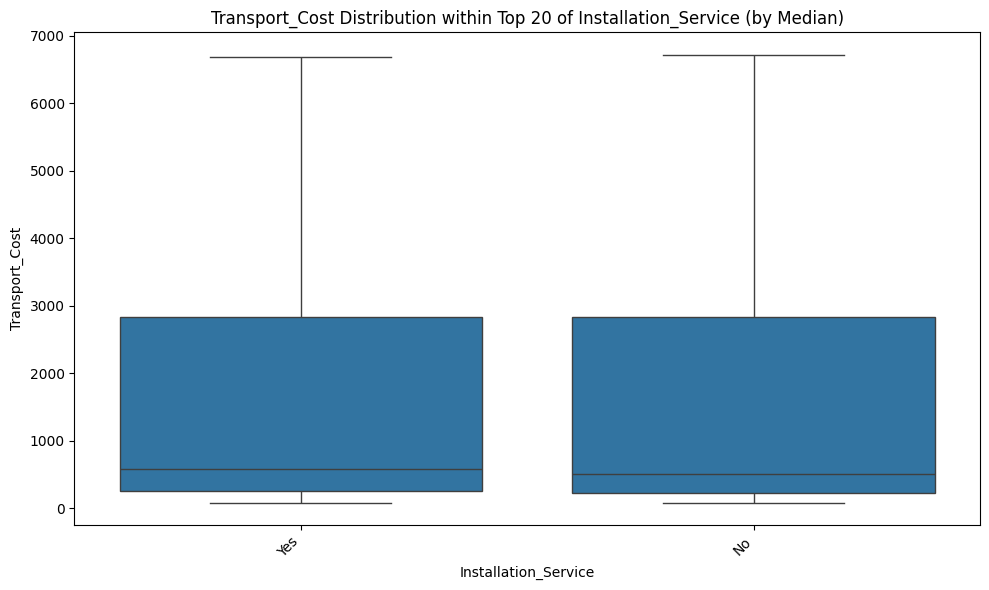

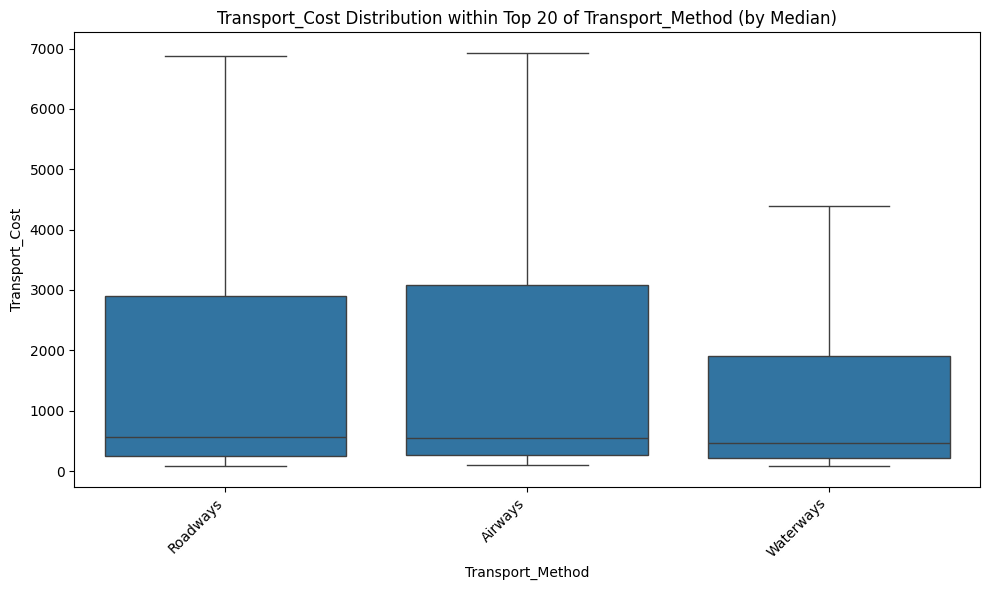

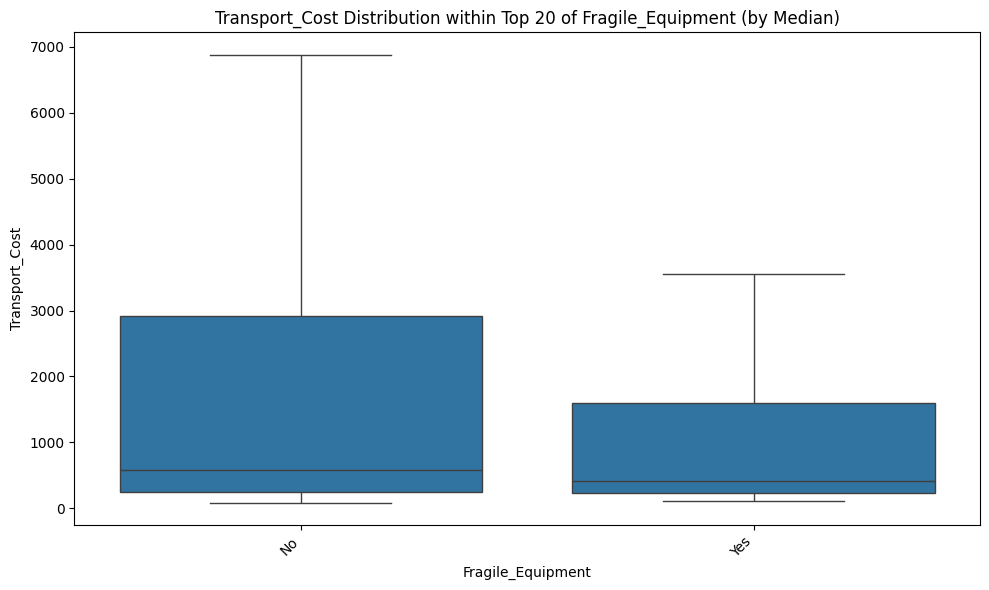

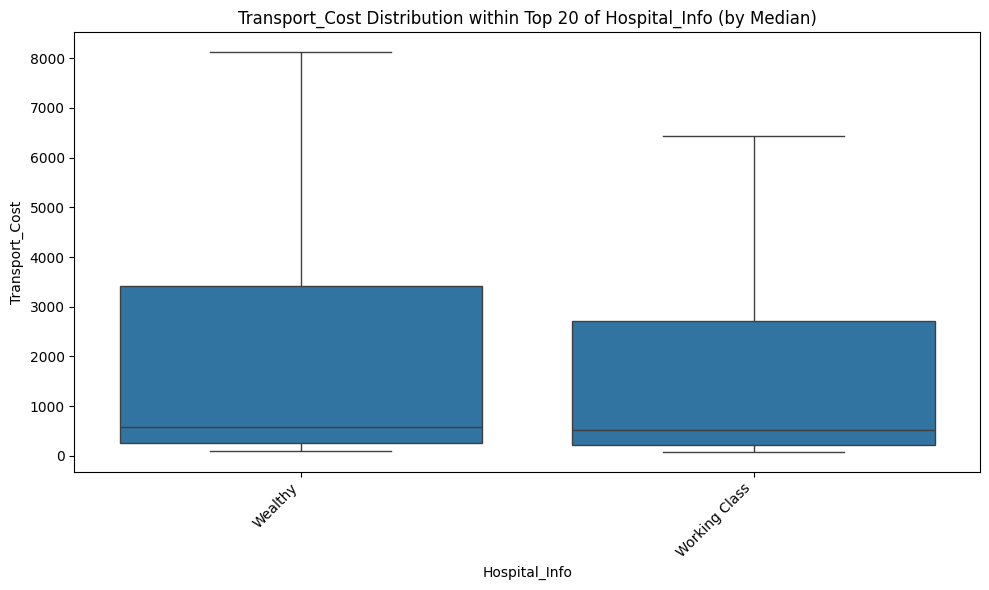

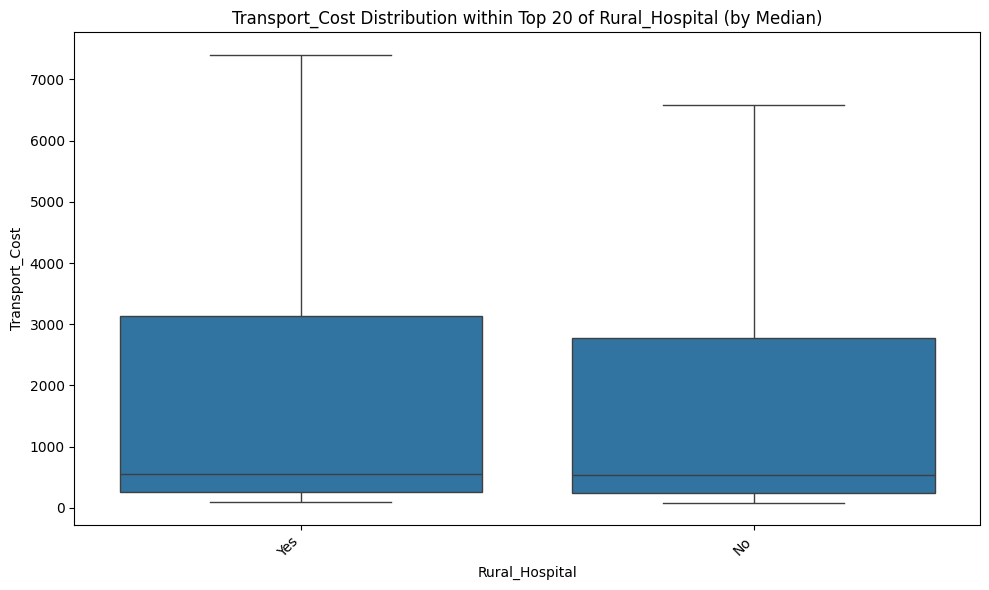

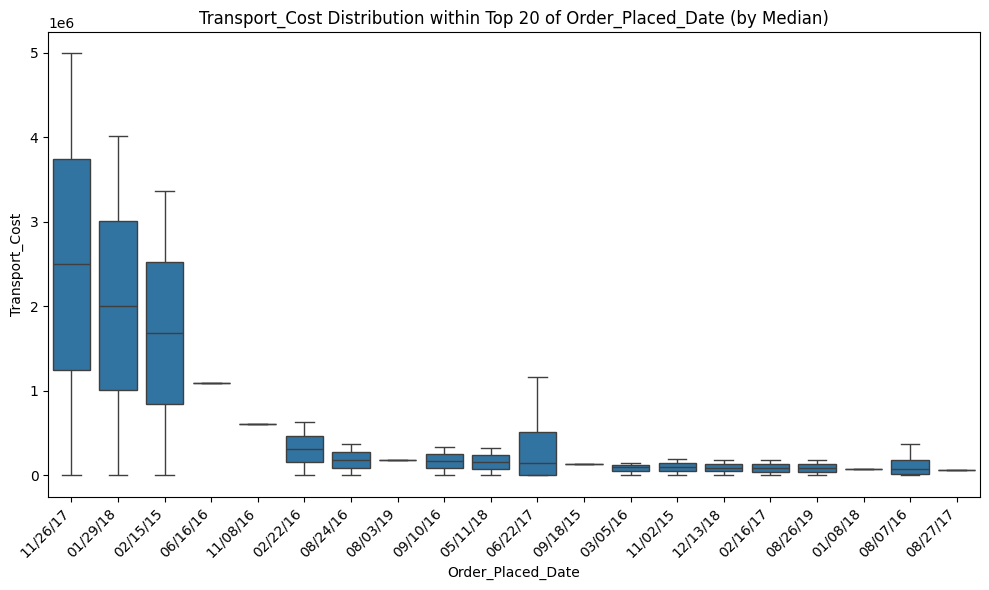

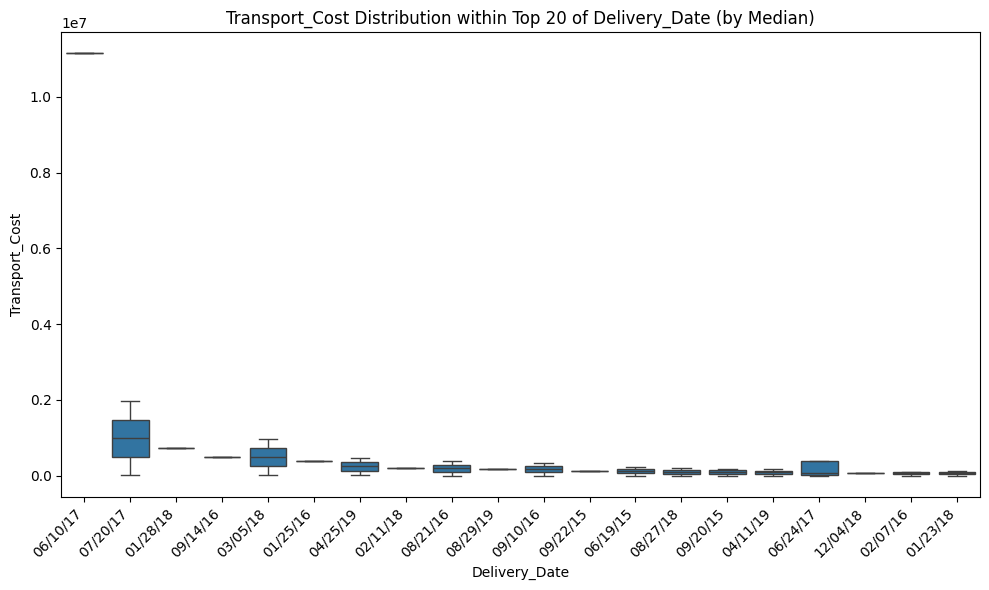

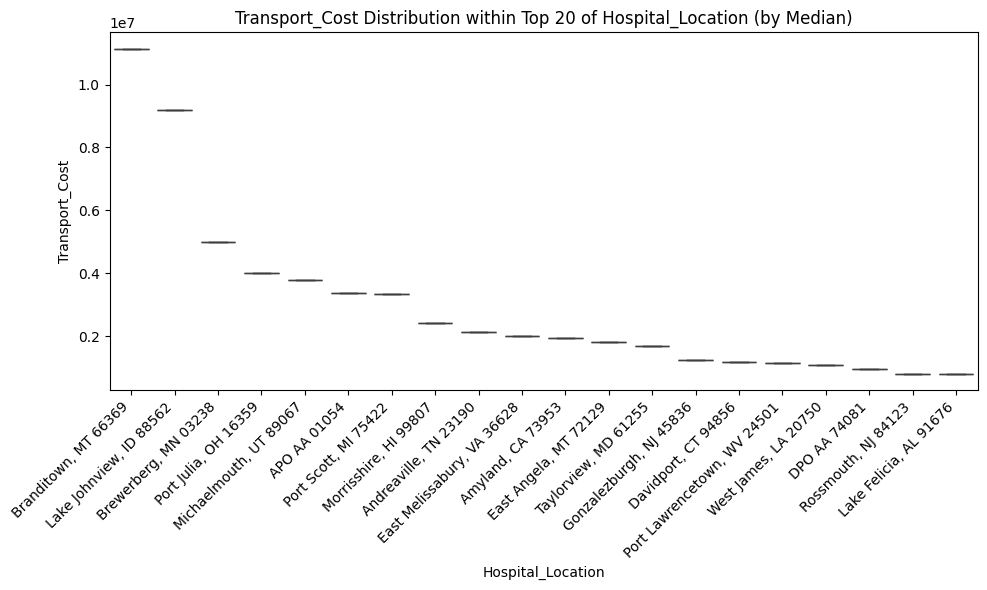

In [23]:
if target_col in df.columns and categorical_cols and pd.api.types.is_numeric_dtype(df[target_col]):
     print(f"\n--- Categorical Features vs Target ({target_col}) ---")
     for col in categorical_cols:
         plt.figure(figsize=(10, 6))
         # Consider boxplot or violin plot for comparing distributions across categories
         order = df.groupby(col)[target_col].median().sort_values(ascending=False).iloc[:20].index # Top 20 by median
         sns.boxplot(x=df[col], y=df[target_col], order=order, showfliers=False) # showfliers=False to reduce noise
         plt.title(f'{target_col} Distribution within Top 20 of {col} (by Median)')
         plt.xlabel(col)
         plt.ylabel(target_col)
         plt.xticks(rotation=45, ha='right')
         plt.tight_layout()
         plt.show()

In [24]:
print("\n--- EDA Complete ---")


--- EDA Complete ---
